# Uncertainty estimation using ensembles of partly independent MLP models

**Model description:**

-- Network outputs two values in the final layer, corresponding to the predicted **mean** and **variance** by treating the observed value as a sample from a Gaussian distribution

-- Ensemble members are trained on different bootstrap samples of the original training set; the mean and variance of a mixture are given by $$\mu_{*}(\mathbf{x})=M^{-1} \sum_{m} \mu_{\theta_{m}}(\mathbf{x}),$$  $$\sigma_{*}^{2}(\mathbf{x})=M^{-1} \sum_{m}\left(\sigma_{\theta_{m}}^{2}(\mathbf{x})+\mu_{\theta_{m}}^{2}(\mathbf{x})\right)-\mu_{*}^{2}(\mathbf{x}),$$ respectively.



In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
import torch
import torch.nn as nn
from astropy.io import fits
import numpy.ma as ma
from inverse_problem import SpectrumDataset, make_loader
from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet

### Define ensemble size

In [3]:
ensemble_size = 6

### Load data

In [4]:
filename = '../data/parameters_base_new.fits'
transform = None
sobj = SpectrumDataset(param_path=filename, source='database', transform=transform)
sample = sobj[1]

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


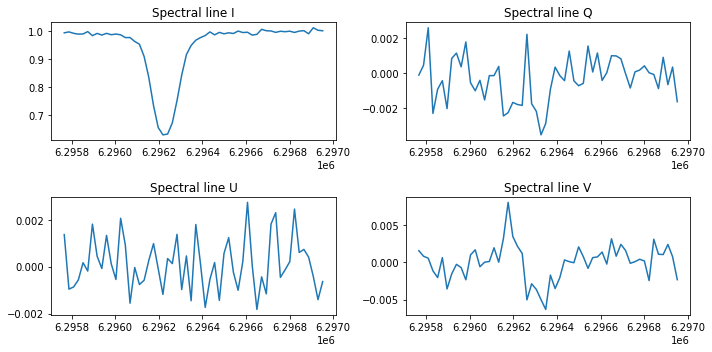

In [5]:
line_type = ['I','Q','U','V']
line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56)) - 6302.5
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(line_arg, sample['X'][0][:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
fig.set_tight_layout(tight = True)

### Prepare data for training

Options:
-- angle transformation
-- log transformation

In [6]:
params = fits.open(filename)[0].data
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)


def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)
rows_mask_params = params_masked_rows(params)
filtered_params = params[rows_mask_params, :]

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device.type)

cpu


In [8]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

transform_name = "conv1d_transform_rescale"

batch_size = 128
num_workers = 1 if 'cuda' in device.type else 0

In [9]:
train_loader, val_loader = make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors=factors, cont_scale=cont_scale,
                                       logB=logB, angle_transformation=angle_transformation,
                                       batch_size=batch_size, num_workers=num_workers)

sample_batch = next(iter(train_loader))

print('Size of spectrum batch: ', sample_batch['X'][0].shape)
print('Size of cont batch: ', sample_batch['X'][1].shape)
print('Size of true params batch: ', sample_batch['Y'].shape)

print(f'\nNumber of batches for train: {len(train_loader)}, for validation: {len(val_loader)}')

Size of spectrum batch:  torch.Size([128, 4, 56])
Size of cont batch:  torch.Size([128, 1])
Size of true params batch:  torch.Size([128, 11])

Number of batches for train: 31243, for validation: 3472


### Create path for saving

In [10]:
model_name = 'conv_ens'
current_time = str(datetime.now().strftime('%m-%d_%H-%M'))
save_path = '../' + model_name + '_' + current_time + '/'
Path(save_path).mkdir(parents=True, exist_ok=True)

save_path

'../conv_ens_12-19_20-54/'

## Train model
`output_dim=22` for uncertainty estimation

In [11]:
data_loader = [make_loader(data_arr=filtered_params, transform_name=transform_name,
                                       factors = factors, cont_scale= cont_scale,
                                       angle_transformation = angle_transformation, logB = logB,
                                       batch_size=128) for _ in range(ensemble_size)]

# print characteristics for the first model in the ensemble
sample_batch = next(iter(data_loader[0][0]))
print(sample_batch['X'][0].shape, sample_batch['X'][1].shape, sample_batch['Y'].shape)
print(f"Number of batches for train: {len(data_loader[0][0])}, for validation: {len(data_loader[0][1])}")

torch.Size([128, 4, 56]) torch.Size([128, 1]) torch.Size([128, 11])
Number of batches for train: 31243, for validation: 3472


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = [PIMLPConvNet(top_output=22).to(device) for _ in range(ensemble_size)]

In [22]:
criterion = nn.MSELoss()
optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99)) for model in ensemble]

In [28]:
def mdn_cost(mu, sigma, y):
    dist = torch.distributions.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y))


def fit_step(model, optimizer, dataloader, max_steps=None):
    train_loss = 0.0
    train_it = 0
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps, len(dataloader))

    with tqdm(desc="batch", total=total, position=0, leave=True) as pbar_outer:
        for i, inputs in enumerate(dataloader):
            if i == total:
                break
            x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
            y = inputs['Y'].to(device)
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            optimizer.zero_grad()

            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_it += 1
            if train_it % 10 == 0:
                pbar_outer.update(10)
        return train_loss / train_it


def eval_step(model, dataloader, max_steps = None):
    if max_steps is None:
        max_steps = float('inf')
    total = min(max_steps,len(dataloader))
    model.eval()
    val_loss = 0.0
    val_it = 0
    for i, inputs in enumerate(dataloader):
        if i==total:
            break
        x = [inputs['X'][0].to(device), inputs['X'][1].to(device)]
        y = inputs['Y'].to(device)

        with torch.no_grad():
            outputs = model(x)
            outputs_mean = outputs[:, :11]
            outputs_sigma = torch.exp(outputs[:, 11:])
            losses = [mdn_cost(outputs_mean[:, ind], outputs_sigma[:, ind], y[:, ind])
                      for ind in range(11)]
            loss = torch.stack(losses).mean()
            val_loss += loss.item()
            val_it += 1
    return val_loss / val_it

In [24]:
def save_model(model, optimizer, epoch, loss, path='../'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss},
        path + f'ep{epoch}.pt')

#### Train simple convolutional model

In [30]:
model = ensemble[0]
optimizer = optimizers[0]

In [19]:
%%time
max_train_steps = None
max_val_steps = None
best_valid_loss = float('inf')
history = []
loss_history = []
log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
n_epochs = 3
path_to_save = save_path
log_dir=path_to_save
with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
    for epoch in range(n_epochs):
        train_loss = fit_step(train_loader, max_train_steps)
        val_loss = eval_step(val_loader, max_val_steps)
        history.append((train_loss, val_loss))
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            save_model(model, optimizer, epoch, val_loss, save_path + 'model_' + str(i) + '_')
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                               v_loss=val_loss))

batch:   0%|          | 0/31243 [00:00<?, ?it/s]461.27s/it]


Epoch 001 train_loss: -0.1612 val_loss -1.1058


batch:   0%|          | 0/31243 [00:00<?, ?it/s]663.19s/it]


Epoch 002 train_loss: -2.3502 val_loss -2.5064


epoch: 100%|██████████| 3/3 [11:15:37<00:00, 13512.61s/it] 


Epoch 003 train_loss: -2.5075 val_loss -2.5039
CPU times: user 2d 6min 8s, sys: 11h 44min 16s, total: 2d 11h 50min 24s
Wall time: 11h 15min 37s


#### Train ensemble

In [ ]:
%%time
max_train_steps = 100
max_val_steps = 50
best_valid_loss = [float('inf') for i in range(ensemble_size)]

history = [[] for i in range(ensemble_size)]
loss_history = [[] for i in range(ensemble_size)]

log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f}"
n_epochs = 2
log_dir=save_path


with tqdm(desc="epoch", total = n_epochs, position=0, leave=True) as pbar_outer:
    for epoch in range(n_epochs):
        val_losses = []
        train_losses = []
        for i, model in enumerate(ensemble):
            optimizer = optimizers[i]
            train_loss = fit_step(model, optimizer, data_loader[i][0], max_train_steps)
            val_loss = eval_step(model, data_loader[i][1], max_val_steps)

            history.append((train_loss, val_loss))
            if val_loss < best_valid_loss[i]:
                best_valid_loss[i] = val_loss
                save_model(model, optimizer, epoch, val_loss, save_path + 'model_' + str(i) + '_')

            val_losses.append(val_loss)
            train_losses.append(train_loss)


        val_loss, train_loss = min(val_losses), min(train_losses)
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch + 1, t_loss=train_loss,
                                               v_loss=val_loss))

batch:   0%|          | 0/100 [00:00<?, ?it/s]15s/it]


Epoch 001 train_loss: 3.3210 val_loss 2.2658


batch:  50%|█████     | 50/100 [00:24<00:25,  1.98it/s]